# **FIRST TASK - FRUIT SEGMENTATION AND  DEFECT DETECTION**

Importing the needed modules. To get the image mount your Google Drive path and put Images inside a folder called 'FruitImages'.


In [84]:
import warnings
warnings.filterwarnings("ignore")
import sys
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
from google.colab.patches import cv2_imshow
import heapq
import math
from google.colab import drive
drive.mount('/content/drive/')
%cd drive/MyDrive//FruitImages
import numpy as np
import pandas as pd
from IPython.display import display, HTML
import matplotlib.pyplot as plt

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
[Errno 2] No such file or directory: 'drive/MyDrive//FruitImages'
/content/drive/MyDrive/FruitImages


In [85]:
# importing the images
img = cv.imread('C0_000001.png', cv.IMREAD_GRAYSCALE)
img_col = cv.imread('C1_000001.png',cv.IMREAD_GRAYSCALE)
# global thresholding
#_,th1 = cv.threshold(img,100,255,cv.THRESH_BINARY)

### **Creating a binary mask**

Now, we want to create a mask from the segmented image, in order to separate the object from the background. In order to do so, we first fulfill the holes inside the foreground using a Dilation operation inside the function `generate_binarymask`. 



GENERATED MASK 



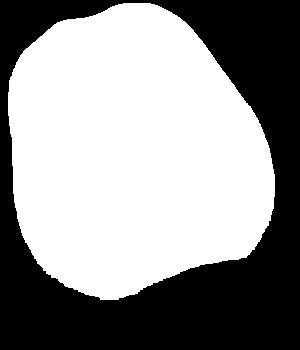

In [86]:
#img_seg=th1
# Reading the input image 

def generate_binarymask(img):
  # Taking a matrix of size 5 as the kernel 
  _,img_bin = cv.threshold(img,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
  kernel = np.ones((3,3), np.uint8)
  img_dilate = cv.dilate(img_bin, kernel, iterations=9)
  return img_dilate

print("GENERATED MASK \n")
binary_mask = generate_binarymask(img)
cv2_imshow(binary_mask) 

Now we apply the binarized mask on the image by performing a bitwise_and operation



APPLY MASK ON GRAYSCALE IMAGE 



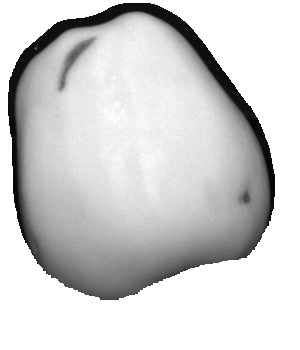


APPLY MASK ON COLORED IMAGE 



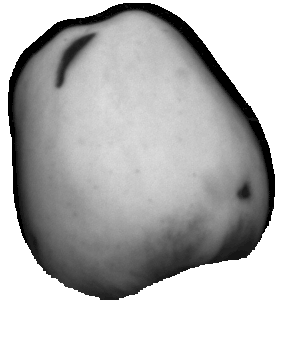

In [87]:
def apply_mask(img_orig, mask):
  result = cv.bitwise_and(img_orig,mask)
  result[mask==0] = 255
  return result

mask_ongray = apply_mask(img,binary_mask)
mask_oncolor = apply_mask(img_col,binary_mask)

print("\nAPPLY MASK ON GRAYSCALE IMAGE \n")
cv2_imshow( mask_ongray)
print("\nAPPLY MASK ON COLORED IMAGE \n")
cv2_imshow( mask_oncolor)

Now, its time for performing Edge Detection, for which we will use Canny.


CONTOURS OF THE EDGES: 



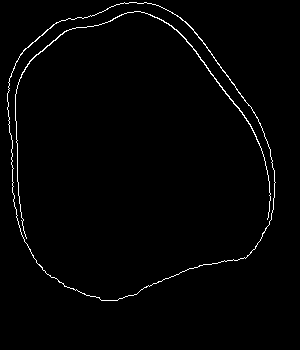

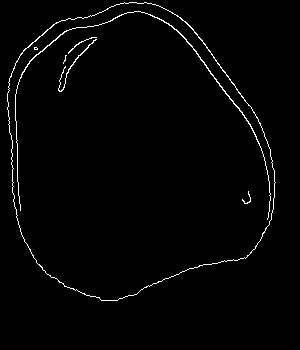

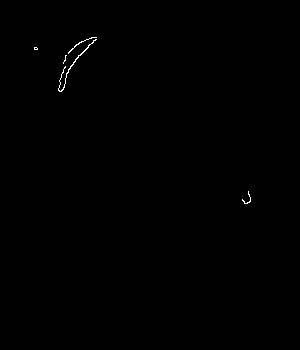

In [88]:
def find_edges(mask_ongray,t1,t2,n1,n2):
  edges_high_thresh = cv.Canny(mask_ongray,t1,t2)
  cv2_imshow(edges_high_thresh)
  edges_normal = cv.Canny(mask_ongray,n1,n2)
  cv2_imshow(edges_normal)
  segmentation =  edges_normal - edges_high_thresh 
  return segmentation

#n1 n2 must be 150 450 to all images background
print("\nCONTOURS OF THE EDGES: \n")

# CALL WITH PARAMETERS FOR FIRST IMG # 140 155
#segmented_mask= segmentation(300,500,160,170)
#cv2_imshow(segmented_mask)
# CALL WITH PARAMETERS FOR SECOND IMG
#segmented_mask= segmentation(350,500,25,390)
#cv2_imshow(segmented_mask)
# CALL WITH PARAMETERS FOR THIRD IMG
#segmented_mask= segmentation(150,400,100,200)

edges_mask = find_edges(mask_ongray,80,450,130,200)
cv2_imshow(edges_mask)


Now we just color the edges on our grayscale image. We will apply a dilation step on the edges in order to expand the contours.

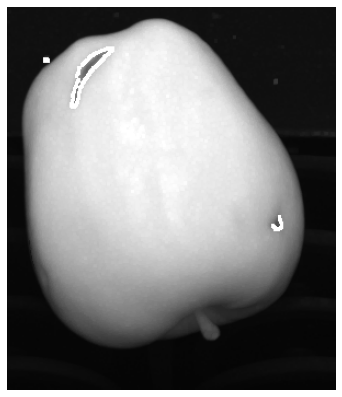

In [89]:
img_orig = cv.cvtColor(cv.imread("C0_000001.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB)
# Draw edges
def color_edges(edges,img):
  for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
      if edges[i,j]==0:
        continue;
      else:
        img[i,j] = edges[i,j] 
  kernel = np.ones((3,3), np.uint8)
  img=cv.dilate(img,kernel,iterations=1)
  return img


img_edges = color_edges(edges_mask,img_orig)

plt.figure(figsize=(20,20));
plt.subplot(2,3,1);
plt.axis('off')
plt.imshow(img_edges);

# **SECOND TASK**

In [90]:
img_color04 = cv.cvtColor(cv.imread("C1_000004.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB) 
img_color05 = cv.cvtColor(cv.imread("C1_000005.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB) 

img_train04 =  img_color04[180:210,150:160]

img_train05 =  img_color05[100:130,70:160]

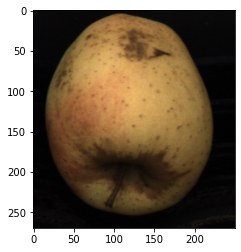

In [91]:
plt.imshow(img_color04);

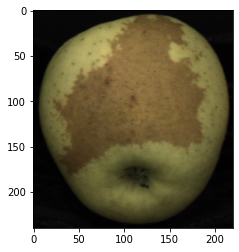

In [92]:
plt.imshow(img_color05); 

As training image we will select a russet region in the apple. Then, the reference color will be computed based on the russet

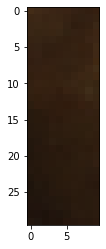

In [93]:
plt.imshow(img_train04);

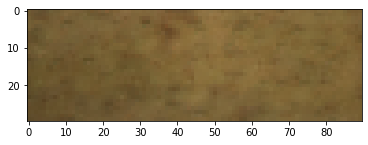

In [94]:
plt.imshow(img_train05);

In [95]:
def mahalanobis(img,img_train,treshold):
  red = img_train[:,:,0] #red 
  green = img_train[:,:,1] #green
  blue = img_train[:,:,2] #blue

  mean = np.array([red.mean(),green.mean(),blue.mean()])
  covariance = np.cov([red.ravel(), green.ravel(), blue.ravel()])
  inv_cov = np.linalg.inv(covariance)
  eigval,eigvec = cv.eigenNonSymmetric(inv_cov)

  eigvec=np.array(eigvec)
  img=np.array(img)
  
  for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
      img_prime= np.dot(img[i,j,:]-mean,eigvec)

      if ((img_prime[0])**2/eigval[0]
              +  (img_prime[1])**2/eigval[1]
              +  (img_prime[2])**2/eigval[2]) <= treshold**2 :  
          img[i,j] = 0        
  return img

def macro_russet(img):
  hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
  mask = cv.inRange(hsv, (99,50,20), (104,255,255))
  kernel = np.ones((2,2), np.uint8)
  russet = cv.bitwise_and(img,img, mask=mask)
  return russet

def find_russet(img):
  for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
      if img[i,j,0]>= 30 and img[i,j,1]>=5 and img[i,j,2]>=5: 
        img[i,j,0]=255
        img[i,j,1]=255
        img[i,j,2]=255
  return img

### Method that replaces the russet value in the original image
def color_russet(img_russet,img):
  for i in range(0,img.shape[0]):
    for j in range(0,img.shape[1]):
      if img_russet[i,j,0]<=30 and img_russet[i,j,1]<=5 or img_russet[i,j,2]<=5:
        continue;
      else:
        img[i,j] = img_russet[i,j]
  return img+255

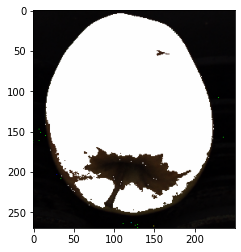

In [96]:
train04 = mahalanobis(img_color04, img_train04, 200) #Good values for RGB 8
russet04 = find_russet(train04)
img_color04 = cv.cvtColor(cv.imread("C1_000004.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB)
russet_result04 = color_russet(russet04,img_color04)
plt.imshow(russet_result04);

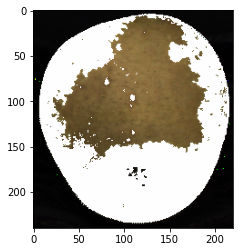

In [97]:
train05 = mahalanobis(img_color05, img_train05,100) #Good values for RGB 8
russet05 = find_russet(train05)
img_color05 = cv.cvtColor(cv.imread("C1_000005.png", cv.IMREAD_COLOR),cv.COLOR_BGR2RGB)
russet_result05 = color_russet(russet05,img_color05)
plt.imshow(russet_result05)

# **THIRD TASK - Kiwi Detection**

In [98]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

from google.colab.patches import cv2_imshow

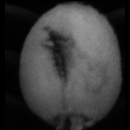

In [99]:
# Python program to illustrate
# template matching
import cv2 as cv
import numpy as np
img_rgb = cv.imread('C0_000007.png')
kiwi= cv.imread('C1_000010.png',0) 
kiwi_template = kiwi[10:175,40:170]

def kiwi_detection(img_rgb,template):
  img_gray = cv.cvtColor(img_rgb, cv.COLOR_BGR2GRAY)
  # Store width and height of template in w and h
  w, h = kiwi_template.shape[::-1]
  # Perform match operations.
  res = cv.matchTemplate(img_gray,template,cv.TM_CCOEFF_NORMED)
  # Specify a threshold
  threshold = 0.79
  # Store the coordinates of matched area in a numpy array
  loc = np.where( res >= threshold)
  # Draw a rectangle around the matched region.
  for pt in zip(*loc[::-1]):
    cv.rectangle(img_rgb, pt, (pt[0] + w, pt[1] + h), (0,0,0), 1)
  rectangle=img_rgb[pt[1]:pt[1]+w,pt[0]:pt[0]+w]

  return img_rgb,rectangle

img_rectangle,rectangle = kiwi_detection(img_rgb=img_rgb, template=kiwi_template)

cv2_imshow(rectangle)


In [100]:
rectangle = cv.cvtColor(rectangle, cv.COLOR_BGR2GRAY)
_, img_threshtozero = cv.threshold(rectangle ,0,255, cv.THRESH_BINARY+cv.THRESH_OTSU)

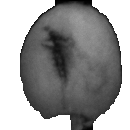

In [101]:
def kiwi_mask(rectangle, img_bin, dilation=False):
  if dilation==True:
    kernel = np.ones((5,5), np.uint8)
    img_bin= cv.dilate(img_bin,kernel,iterations=3)
    kernel = np.ones((3,3), np.uint8)
    img_bin= cv.erode(img_bin,kernel,iterations=5)

  mask = apply_mask(rectangle,img_bin)
  return mask


kiwi_mask = kiwi_mask(rectangle, img_threshtozero, True)
cv2_imshow(kiwi_mask)

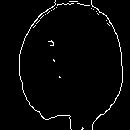

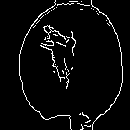

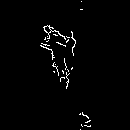

In [102]:
edges_mask = find_edges(kiwi_mask,150,180, 80,100)
cv2_imshow(edges_mask)

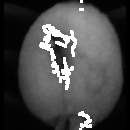

In [103]:
img_edges2 = color_edges(edges_mask,rectangle)
cv2_imshow(img_edges2)